In [1]:
import numpy as np
import coffea
import awkward as ak
from coffea.nanoaod import NanoEvents
from coffea import processor, hist
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fname = "/Users/herwig/Desktop/dominic/data/met100_skim.root"
events = NanoEvents.from_file(fname)

Can directly get the objects and check their properties

In [3]:
# truth collections
truth_n2 = events.GenPart[
    (events.GenPart.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_n1 = events.GenPart[
    (events.GenPart.pdgId == 1000022)
    & (events.GenPart.parent.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
truth_eles = events.GenPart[truth_ele_mask]

dM = truth_n2.mass-truth_n1.mass
mask = truth_eles.counts==2
ee_events = truth_eles[mask]
dM = dM[mask]
ee=ee_events[:,0]+ee_events[:,1]
ee.mass [ (dM<2)[:,0] ]


/Users/herwig/miniconda3/envs/coffea/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


array([0.7674082 , 0.8898775 , 0.64670414, ..., 0.8615264 , 0.6542648 ,
       0.46107867], dtype=float32)

Do the full analysis in a processor

In [160]:
class TruthAna(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "N2-N1 mass difference")
        mass_axis = hist.Bin("mass", r"$m_{ee}$ [GeV]", 40, 0, 4)
        pt_axis = hist.Bin("pt", r"$p_{T,e}$ [GeV]", 40, 0, 8)
        lead_pt_axis = hist.Bin("pt", r"$p_{T,e1}$ [GeV]", 40, 0, 8)
        sub_pt_axis = hist.Bin("pt", r"$p_{T,e2}$ [GeV]", 40, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, lead_pt_axis),
            'pt_sub': hist.Hist("Counts", dataset_axis, sub_pt_axis),

            # Efficiencies: for reco analysis, binned in truth pt
            'pt_all_truth': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_all_truth_matched': hist.Hist("Counts", dataset_axis, pt_axis),
            # Fake rates: for reco analysis, binned in reco pt
            'pt_all_reco_unmatched': hist.Hist("Counts", dataset_axis, pt_axis),

            # unused for now
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        
        truth_n2 = events.GenPart[ (events.GenPart.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_n1 = events.GenPart[(events.GenPart.pdgId == 1000022)
            & (events.GenPart.parent.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
        all_truth_eles = events.GenPart[truth_ele_mask]
        # calc dM
        dM = truth_n2.mass-truth_n1.mass
        # get ee events
        event_mask = (all_truth_eles.counts==2)
        dM = dM[event_mask]
        truth_eles = all_truth_eles[event_mask]
        ee = truth_eles[:,0]+truth_eles[:,1]
        lead = truth_eles[truth_eles.pt.argmax()]
        sublead = truth_eles[truth_eles.pt.argmin()]
        

        #match truth_eles
        reco_eles = events.ElectronBPark[event_mask]
        # cut down on combinatorics by picking out the 'good ones' first
        reco_eles_prematched = events.ElectronBPark[events.ElectronBPark.genPartIdx >=0]
        reco_eles_prematched = reco_eles_prematched[event_mask]
        tr_pairs = truth_eles.cross(reco_eles_prematched, nested=True)
        t, r = tr_pairs.unzip()
        drs = t.delta_r(r)
        #t_match = t[drs.min() < 0.1]
        #r_match = r[drs.min() < 0.1]
        idx = drs.argmin()
        r_match = tr_pairs.i1[idx[drs[idx] < 0.05]].flatten(1)
        t_match = tr_pairs.i0[idx[drs[idx] < 0.05]].flatten(1)
        #should be left with only one pairing given the right dR cut

        # unmatched electrons for fake rate
        reco_eles_unmatched = events.ElectronBPark[events.ElectronBPark.genPartIdx <0]
        reco_eles_unmatched = reco_eles_unmatched[event_mask]

        ## get the reco electrons
        #truthMatched = (events.ElectronBPark.genPartIdx >=0)
        #reco_matched = events.ElectronBPark[truthMatched]
        #reco_unmatched = events.ElectronBPark[~truthMatched]
        #truth_matched = events.GenPart[ reco_matched.genPartIdx ]
        ## some matching disagreement... 
        #match_genIdx_unique = ak.fromiter([list(set(x)) for x in reco_matched.genPartIdx.tolist()])

        ## masking
        #reco_matched = reco_matched[event_mask]
        #reco_unmatched = reco_unmatched[event_mask]
        #truth_matched = truth_matched[event_mask]
        
        
        isDM1 = (dM<2)[:,0]
        subsets={'dM1': isDM1,'dM3': ~isDM1}
        for tag, rule in subsets.items():
            out["mass"].fill(
                dataset=tag, #events.metadata["dataset"],
                mass=ee[rule].mass.flatten(),
            )
            out["pt_lead"].fill(dataset=tag, pt=lead[rule].pt.flatten())
            out["pt_sub"].fill(dataset=tag, pt=sublead[rule].pt.flatten())
            
            # Efficiencies: for reco analysis, binned in truth pt
            out['pt_all_truth'].fill(dataset=tag, pt=truth_eles[rule].pt.flatten())
            out['pt_all_truth_matched'].fill(dataset=tag, pt=t_match[rule].pt.flatten())
            # pt resolution
            
            # Fake rates: for reco analysis, binned in reco pt
            out['pt_all_reco_unmatched'].fill(dataset=tag, pt=reco_eles_unmatched[rule].pt.flatten())
            out['cutflow'][tag] += rule.sum()
            
        return out

    def postprocess(self, accumulator):
        return accumulator

In [165]:
samples = { "N2N1": [fname] }

result = processor.run_uproot_job(
    samples,
    "Events",
    TruthAna(),
    processor.iterative_executor,
    {"nano": True},
)
# postproc
n1 = result['cutflow']['dM1']
n3 = result['cutflow']['dM3']
result["pt_all_reco_unmatched"].scale({'dM1': 1./n1, 'dM3': 1./n3}, axis='dataset')



/Users/herwig/miniconda3/envs/coffea/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


In [166]:
result['cutflow']

defaultdict_accumulator(int, {'dM1': 7892, 'dM3': 6389})

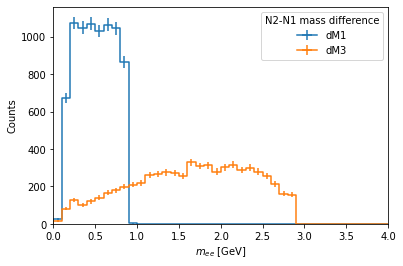

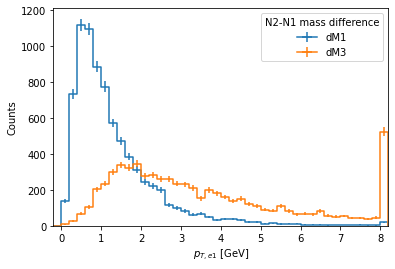

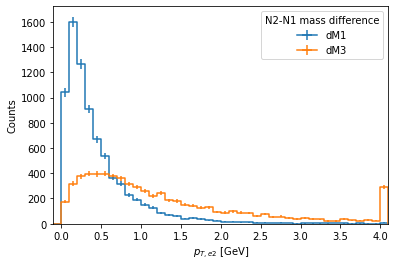

In [167]:
plt.figure()
hist.plot1d(result["mass"])
plt.figure()
hist.plot1d(result["pt_lead"],overflow='all')
plt.figure()
hist.plot1d(result["pt_sub"],overflow='all')

<Figure size 432x288 with 0 Axes>

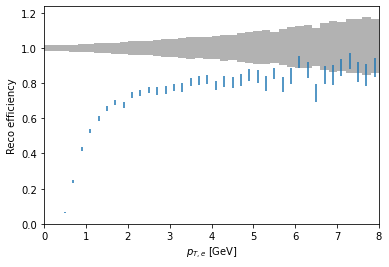

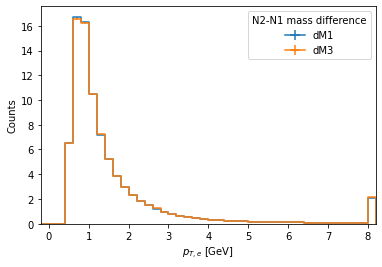

In [173]:
plt.figure()
hist.plotratio(num=result["pt_all_truth_matched"].integrate("dataset"), 
               denom=result["pt_all_truth"].integrate("dataset")) #, error_opts={"marker": "x"})
plt.ylabel("Reco efficiency")

plt.figure()
hist.plot1d(result["pt_all_reco_unmatched"],overflow='all')


Now try things with the reco objects

In [62]:
truthMatched = (events.ElectronBPark.genPartIdx >=0)
real_reco = events.ElectronBPark[truthMatched]
fake_reco = events.ElectronBPark[~truthMatched]
#real_reco.counts
#real_reco.genPartIdx #.distincts()
real_reco_matches = events.GenPart[ real_reco.genPartIdx ]
isDM1 = (dM<2)[:,0]
#events.GenPart[ real_reco ]
#fake.counts
real_reco_masked = real_reco[mask]
#real_reco_masked[isDM1].pt
#help(truth_eles)

#how to check whether a genParticle matches a BPark ele?
#truth_ele_mask
#real_reco_matches
#real_reco.genPartIdx.argcross( events.GenPart[truthMatched] )
#truthMatched.argmatch(truthMatched)
#events.GenPart
#real_reco.genPartIdx.argcross( events.GenPart[truthMatched] )
#real_reco.genPartIdx.
#unique_genIdx = ak.fromiter([list(set(x)) for x in real_reco.genPartIdx.tolist()])
#l = [list(set(ll)) for ll in l]
#real_reco

In [61]:
#help(events.GenPart)
reco_eles_prematched = events.ElectronBPark[events.ElectronBPark.genPartIdx >=0]
#tr_pairs = truth_eles.argcross(reco_eles_prematched, nested=True)
tr_pairs = truth_eles.cross(reco_eles_prematched, nested=True)
#tr_pairs.reco_eles_prematched
t, r = tr_pairs.unzip()
drs = t.delta_r(r)
truth_eles.eta
reco_eles_prematched.eta
t_match = t[drs.min() < 0.1]
t_match
#truth_eles.localindex
#t


ValueError: both JaggedArrays must have the same length

In [132]:
truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
all_truth_eles = events.GenPart[truth_ele_mask]
# get ee events
event_mask = (all_truth_eles.counts==2)
truth_eles = all_truth_eles[event_mask]

#match truth_eles
reco_eles = events.ElectronBPark #[event_mask]
# cut down on combinatorics by picking out the 'good ones' first
reco_eles_prematched = reco_eles[events.ElectronBPark.genPartIdx >=0]
reco_eles_prematched = reco_eles_prematched[event_mask]
tr_pairs = truth_eles.cross(reco_eles_prematched, nested=True)
t, r = tr_pairs.unzip()
drs = t.delta_r(r)
idx = drs.argmin()
r_match = tr_pairs.i1[idx[drs[idx] < 0.05]]
t_match = tr_pairs.i0[idx[drs[idx] < 0.05]]

#print(reco_eles_prematched.size)
#print(r_match.size)
#print(t_match.size)
print(t_match.flatten(1).size)
print(t_match.size)
n=3
print(reco_eles_prematched[:n].counts)
print(truth_eles[:n].counts)
#print(reco_eles_prematched[:n])
#print(truth_eles[:n])
print(r_match[:n])
print(t_match[:n])
print(r_match.flatten(1)[:n])

#print(tr_pairs[:n].summary)
#idx

#matched_t.flatten()
#isDM1 = (dM<2)[:,0]
#t_match[isDM1] #.pt.flatten()




14281
14281
[1 0 5]
[2 2 2]
[[[<ElectronBPark 17>] []] [[] []] [[<ElectronBPark 439>] []]]
[[[<GenPart 23>] []] [[] []] [[<GenPart 319>] []]]
[[<ElectronBPark 17>] [] [<ElectronBPark 439>]]


In [ ]:
genEleIndices = events.GenPart.pt.localindex[truth_ele_mask]


#help(events.ElectronBPark) #.argmatch(events.genPart)
#truthMatched